# Apple Stock Price Prediction using LSTM

In this code, we aim to predict Apple's stock prices for the entire year of 2023 using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network optimized for sequence prediction problems.

## Steps Covered:
1. **Data Retrieval**: Using the `yfinance` library, we fetch historical closing prices of Apple's stock from the beginning of 2020 to the end of October 2023.
2. **Data Preprocessing**:
    - The data is scaled using the `MinMaxScaler` to ensure the LSTM can more easily capture patterns in the data.
    - The data is then split into sequences of 60 days as input features with the next day's closing price as the target variable.
3. **Model Building**:
    - Our LSTM model consists of two LSTM layers.
    - This is followed by two dense layers with the last layer outputting a single value (the predicted stock price).
    - The model uses the `adam` optimizer and Mean Squared Error as the loss function.
4. **Training**: The model is trained using the data from 2020 to 2022.
5. **Prediction**: Using the trained model, predictions are made for the closing stock prices of Apple for the entirety of 2023.

In [38]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = ["yfinance", "numpy", "matplotlib", "pandas", "scikit-learn", "keras"]

# Check and install necessary packages
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        install(package)

# ... [The rest of the code]

[*********************100%%**********************]  1 of 1 completed


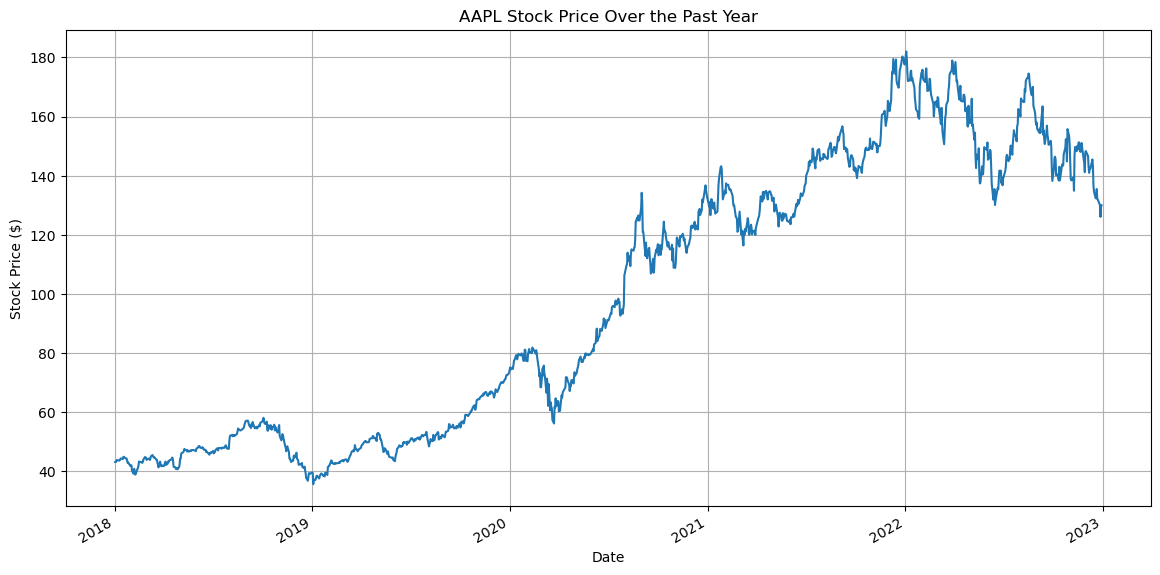

In [33]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch Apple's stock data over the past year
ticker = "AAPL"
stock_data = yf.download(ticker, start="2018-01-01", end="2023-01-01")

# Visualize the closing prices
plt.figure(figsize=(14, 7))
stock_data['Close'].plot(title=f'{ticker} Stock Price Over the Past Year')
plt.ylabel('Stock Price ($)')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [36]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Fetching Apple's stock data
data = yf.download("AAPL", start="2020-01-01", end="2023-10-01")
close_data = data['Close'].values.reshape(-1, 1)

# Scaling the closing prices
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_data)

# Preparing the data
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=50, batch_size=32, verbose=0)  # Increase epochs to 50 for potentially better results

# Predicting the prices for 2023
test_data = scaled_data[len(scaled_data) - 60 - 365:, :]
X_test = []
for i in range(60, test_data.shape[0]):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

[*********************100%%**********************]  1 of 1 completed
12/12 [==============================] - 0s 5ms/step


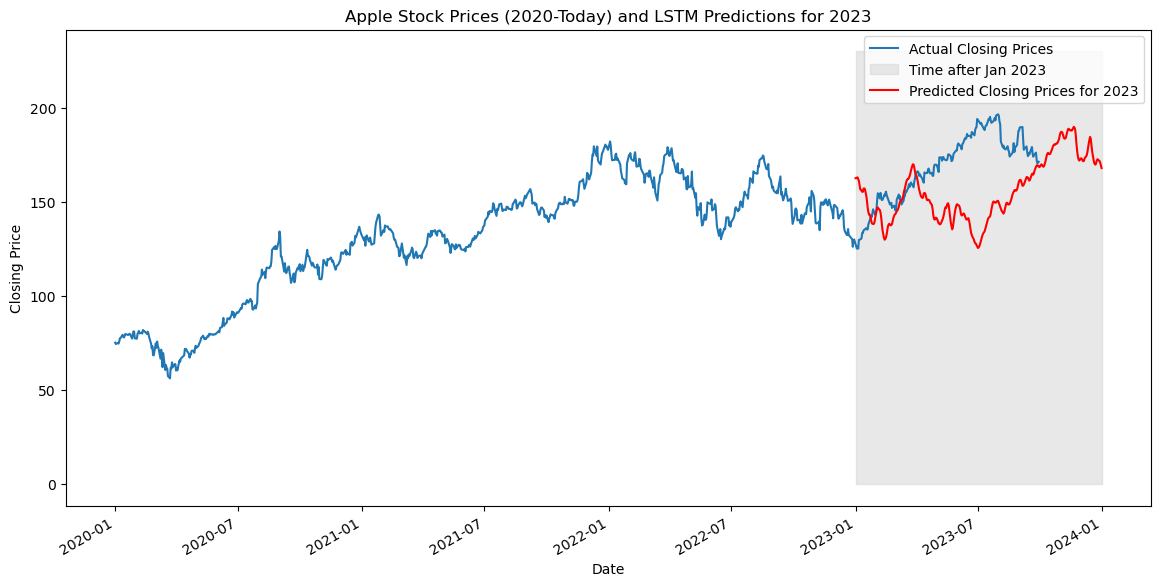

In [42]:
# ... [rest of the code above this remains unchanged]

# Plotting
plt.figure(figsize=(14,7))
data['Close'].plot(label="Actual Closing Prices")  # Label for the blue line (actual closing prices)
predicted_dates = pd.date_range(start="2023-01-01", periods=365, freq='D')
plt.fill_between(predicted_dates, 0, 230, color='lightgray', alpha=0.5, label="Time after Jan 2023") # Lighter shade region after Jan 2023
plt.plot(predicted_dates, predicted_prices, label="Predicted Closing Prices for 2023", color='red')
plt.legend()
plt.title("Apple Stock Prices (2020-Today) and LSTM Predictions for 2023")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()
